In [1]:
# Basic imports
from glob import glob
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from shapely.validation import make_valid

# Library imports
from multiview_prediction_toolkit.cameras.derived_cameras import MetashapeCameraSet
from multiview_prediction_toolkit.meshes import TexturedPhotogrammetryMesh
from multiview_prediction_toolkit.utils.geospatial import ensure_geometric_CRS
from multiview_prediction_toolkit.utils.numeric import to_float
from multiview_prediction_toolkit.config import DATA_FOLDER

# Set constants
You should be able to define most of the behavior from these constants

In [2]:
## Parameters to control the outputs
# Repeat the labeling process
RETEXTURE = False
# Points less than this height above the DTM are considered ground
HEIGHT_ABOVE_GROUND_THRESH = 2
# The image is downsampled to this fraction for accelerated rendering 
RENDER_IMAGE_SCALE = 0.25
# Cameras within this distance of the traing data are used in the rendering process
BUFFER_RADIUS_METER = 50
# Tree Radius
TREE_RADIUS_METERS = 2.5
# Downsample target
DOWNSAMPLE_TARGET = 0.1

## Define the inputs
# The input labels
LABELS_FILENAME = Path(DATA_FOLDER, "example_Emerald_Point_data", "inputs", "labels.geojson")
# The mesh exported from Metashape
MESH_FILENAME = Path(DATA_FOLDER,"example_Emerald_Point_data", "inputs", "mesh.ply")
# The camera file exported from Metashape
CAMERAS_FILENAME = Path(DATA_FOLDER,"example_Emerald_Point_data", "inputs", "cameras.xml")
# The digital elevation map exported by Metashape
DTM_FILE = Path(DATA_FOLDER,"example_Emerald_Point_data", "inputs", "dtm.tif")
# The image folder used to create the Metashape project
IMAGE_FOLDER = Path(DATA_FOLDER,"example_Emerald_Point_data", "inputs", "images")

## Define the intermediate results
# Processed geo file
STANDARDIZED_LABELS_FILENAME = Path(DATA_FOLDER, "example_Emerald_Point_data", "intermediate_results", "standardized_labels.geojson")
# Where to save the mesh after labeling
LABELED_MESH_FILENAME = Path(DATA_FOLDER, "example_Emerald_Point_data", "intermediate_results", "labeled_mesh.ply")
# Where to save the rendering label images
RENDER_FOLDER = Path(DATA_FOLDER, "example_Emerald_Point_data", "intermediate_results", "rendered_labels")

# Geospatial processing

Preprocess the geospatial data to be as expected.

<Axes: >

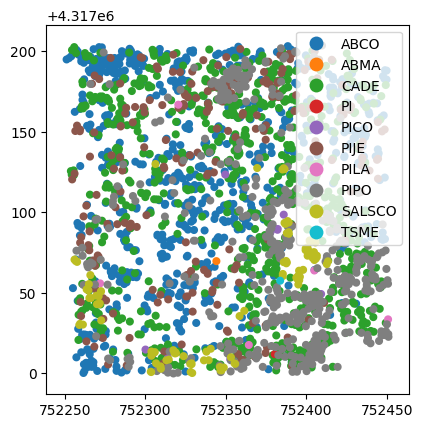

In [3]:
# Load the data
gdf = gpd.read_file(LABELS_FILENAME)
# Ensure that the CRS is geometric so we can buffer
gdf = ensure_geometric_CRS(gdf)

# Now create circles around each point
gdf["geometry"] = gdf["geometry"].buffer(TREE_RADIUS_METERS)

# Split
gdf = gdf.dissolve("Species", as_index=False)
# Drop all but the geometry and the species label
gdf = gdf.loc[:, gdf.columns.intersection(['Species', "geometry"])]
# Write out the sandarized file
gdf.to_file(STANDARDIZED_LABELS_FILENAME)
# Show 
gdf.plot("Species", legend=True)

# Load the mesh and read texture from geopolygon

In [4]:
# Create a labeled version of the mesh from the field data
# if not present or requested
if not Path(LABELED_MESH_FILENAME).is_file() or RETEXTURE:
    # Load the downsampled mesh and apply the texture from the vector file
    mesh = TexturedPhotogrammetryMesh(
        MESH_FILENAME,
        downsample_target=DOWNSAMPLE_TARGET,
        texture=STANDARDIZED_LABELS_FILENAME,
        texture_kwargs={"column_name": "Species"},
        transform_filename=CAMERAS_FILENAME,
    )
    # Get the vertex textures from the mesh
    texture_verts = mesh.get_texture(request_vertex_texture=True, try_verts_faces_conversion=False)
    # Compute which vertices are part of the ground by thresholding the height above the DTM
    ground_mask_verts = mesh.get_height_above_ground(DTM_file=DTM_FILE,threshold=HEIGHT_ABOVE_GROUND_THRESH)

    # Find which vertices are labeled
    is_labeled = texture_verts[:,0] >= 0
    # Find which points are ground that were previously labeled as something else
    is_labeled_and_ground = np.logical_and(is_labeled, ground_mask_verts)

    # Update label names
    label_names = mesh.get_label_names()
    mesh.set_label_names(label_names.tolist() + ["GROUND"])

    # Set a new ground class only for ground that would otherwise be tree
    texture_verts[is_labeled_and_ground, 0] = len(label_names)
    # Apply the texture to the mesh
    mesh.set_texture(texture_verts)

    mesh.save_mesh(LABELED_MESH_FILENAME, save_vert_texture=True)
else:
    mesh = TexturedPhotogrammetryMesh(
        LABELED_MESH_FILENAME, 
        transform_filename=CAMERAS_FILENAME
    )

# Load a set of cameras and downsample them to the region around annotations

In [ ]:
# Create camera set
camera_set = MetashapeCameraSet(CAMERAS_FILENAME, IMAGE_FOLDER)
# Extract cameras near the training data
training_camera_set = camera_set.get_subset_near_geofile(
    STANDARDIZED_LABELS_FILENAME, buffer_radius_meters=BUFFER_RADIUS_METER
)

# Show the mesh

In [ ]:
mesh.vis(
    camera_set=training_camera_set,
    force_xvfb=True
)

# Render the labels onto the images

In [ ]:
mesh.save_renders_pytorch3d(
    camera_set=training_camera_set, render_image_scale=RENDER_IMAGE_SCALE, save_native_resolution=True,
    output_folder=RENDER_FOLDER,
)